<center><h1>Liu_Zihan_HW6</h1></center>

Name: Zihan Liu
<br>
Github Username: zihan0324
<br>
USC ID: 1534981630

## 1. Tree-Based Methods

Import packages

In [67]:
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE

### (a) Download the APS Failure data

In [5]:
df_train = pd.read_csv('../data/aps_failure_training_set.csv', skiprows=20)
print(f"Rows: {df_train.shape[0]}, Columns: {df_train.shape[1]} in training dataset")

df_test = pd.read_csv('../data/aps_failure_test_set.csv', skiprows=20)
print(f"Rows: {df_test.shape[0]}, Columns: {df_test.shape[1]} in test dataset")

Rows: 60000, Columns: 171 in training dataset
Rows: 16000, Columns: 171 in test dataset


In [6]:
df_train['class'] = df_train['class'].apply(lambda x: 0 if x == 'neg' else 1)
df_test['class'] = df_test['class'].apply(lambda x: 0 if x == 'neg' else 1)

In [7]:
# Replacing the na and nan values with np.NaN
df_train.replace(to_replace='nan', value = np.NaN,inplace = True)
df_train.replace(to_replace = 'na', value = np.NaN, inplace = True)

df_test.replace(to_replace='nan', value = np.NaN,inplace = True)
df_test.replace(to_replace = 'na', value = np.NaN, inplace = True)

In [8]:
# Convert data type into numeric
for col in df_train.columns:
    df_train[col] = pd.to_numeric(df_train[col], errors='ignore')
    df_test[col] = pd.to_numeric(df_test[col], errors='ignore')

In [9]:
print(df_train.head())

   class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  \
0      0   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0   
1      0   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0   
2      0   41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0   
3      0      12     0.0  7.000000e+01    66.0     0.0    10.0     0.0   
4      0   60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0   

   ag_001  ag_002  ...     ee_002    ee_003    ee_004    ee_005    ee_006  \
0     0.0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0   
1     0.0     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   
2     0.0     0.0  ...   277378.0  159812.0  423992.0  409564.0  320746.0   
3     0.0     0.0  ...      240.0      46.0      58.0      44.0      10.0   
4     0.0     0.0  ...   622012.0  229790.0  405298.0  347188.0  286954.0   

     ee_007    ee_008  ee_009  ef_000  eg_000  
0  157956.0   73224.0     0.0     0.0     0.

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

Data Imputation Methods:

1. Mean 
2. Median
3. Mode
4. Model-Based Imputation (e.g., KNN regression and classification, Linear Regression)
5. Exprectation Maximization Imputation

In [10]:
# Mean Imputation
def mean_imputation(data):
    mean = np.nanmean(data)
    imputed_data = np.where(np.isnan(data), mean, data)
    
    return imputed_data

In [11]:
warnings.filterwarnings('ignore')
imputed_train_data = pd.DataFrame()
imputed_test_data = pd.DataFrame()

for col in df_train.columns:
    imputed_train_data[col] = mean_imputation(df_train[col])
    imputed_test_data[col] = mean_imputation(df_test[col])

In [12]:
print(imputed_train_data.head())

   class   aa_000    ab_000        ac_000         ad_000  ae_000  af_000  \
0    0.0  76698.0  0.713189  2.130706e+09     280.000000     0.0     0.0   
1    0.0  33058.0  0.713189  0.000000e+00  190620.639314     0.0     0.0   
2    0.0  41040.0  0.713189  2.280000e+02     100.000000     0.0     0.0   
3    0.0     12.0  0.000000  7.000000e+01      66.000000     0.0    10.0   
4    0.0  60874.0  0.713189  1.368000e+03     458.000000     0.0     0.0   

   ag_000  ag_001  ag_002  ...     ee_002    ee_003    ee_004    ee_005  \
0     0.0     0.0     0.0  ...  1240520.0  493384.0  721044.0  469792.0   
1     0.0     0.0     0.0  ...   421400.0  178064.0  293306.0  245416.0   
2     0.0     0.0     0.0  ...   277378.0  159812.0  423992.0  409564.0   
3     0.0     0.0     0.0  ...      240.0      46.0      58.0      44.0   
4     0.0     0.0     0.0  ...   622012.0  229790.0  405298.0  347188.0   

     ee_006    ee_007    ee_008  ee_009  ef_000  eg_000  
0  339156.0  157956.0   73224.0   

#### (ii) Calculate the coefficient of variation

In [13]:
# Concact imputed training data and test data
imputed_data = pd.concat([imputed_train_data, imputed_test_data], axis=0).reset_index(drop=True)

# Compute CV
imputed_data_cv = imputed_data\
                            .apply(lambda x: np.std(x, ddof=1) / np.mean(x)).sort_values(ascending=False)

print(imputed_data_cv)

cf_000    207.335930
co_000    206.941549
ad_000    206.786809
cs_009    192.498194
dj_000    122.169994
             ...    
bo_000      0.462959
bp_000      0.426983
bq_000      0.400370
br_000      0.384004
cd_000      0.000000
Length: 171, dtype: float64


#### (iii) Plot a correlation matrix

In [29]:
corr = imputed_data.drop(columns=['class']).corr()

corr.style.background_gradient(cmap='coolwarm').format(precision=2)

#### (iv) Make scatter plots and box plots

In [30]:
# Select ⌊170⌋ features with highest CV 
N_FEATURES = math.floor(np.sqrt(df_train.shape[1]))

selected_feature = list(imputed_data_cv.head(N_FEATURES).index)
print(selected_feature)

['cf_000', 'co_000', 'ad_000', 'cs_009', 'dj_000', 'as_000', 'dh_000', 'df_000', 'ag_000', 'au_000', 'ak_000', 'az_009', 'ay_009']


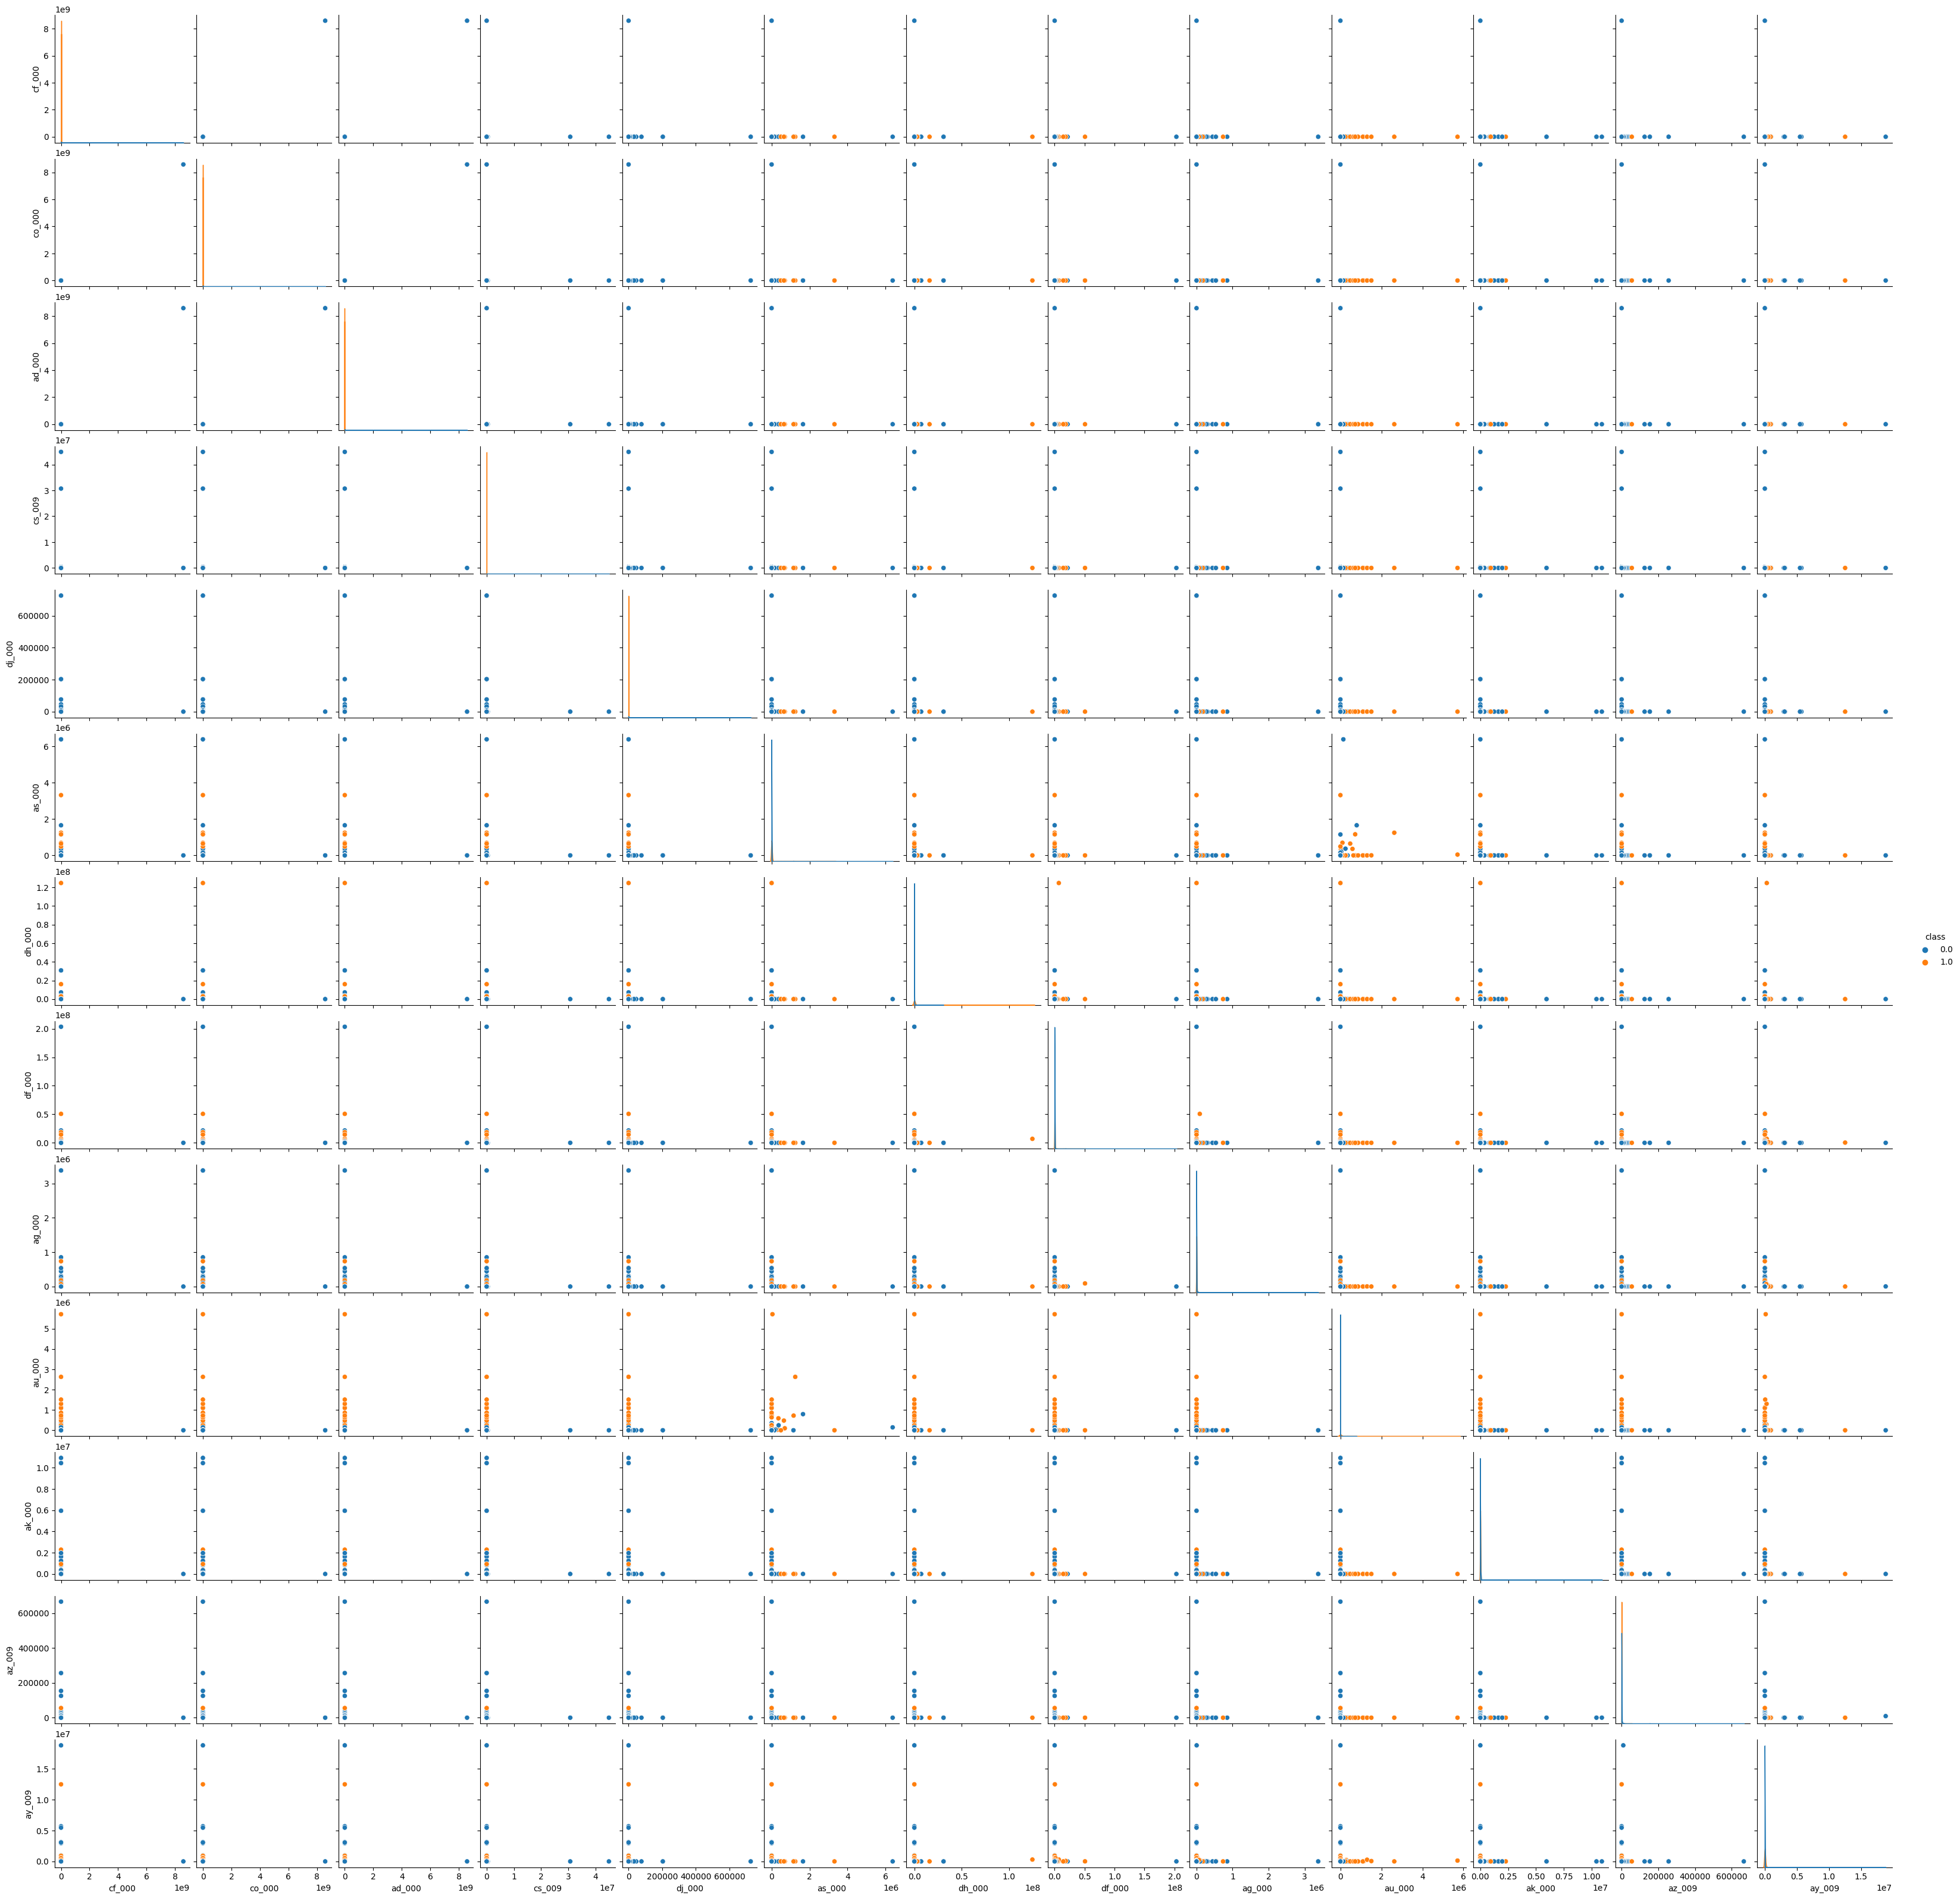

In [32]:
# Plot scatter plot for selected features
warnings.filterwarnings('ignore')
selected_feature.append('class')
sns.pairplot(imputed_data[selected_feature], hue='class')
plt.show()

Basically, it is hard to split because negative class is the majority. For feature 'au_000', it can effectively split 2 classes.

#### (v) Is this data set imbalanced?

In [36]:
print("Percentage of negative class in the training dataset :", round((imputed_train_data[imputed_train_data['class']== 0].shape[0] / imputed_train_data.shape[0]) * 100, 2))
print("Percentage of positive class in the training dataset :", round((imputed_train_data[imputed_train_data['class']== 1].shape[0] / imputed_train_data.shape[0]) * 100, 2))

Percentage of negative class in the training dataset : 98.33
Percentage of positive class in the training dataset : 1.67


In [38]:
print("Percentage of negative class in the test dataset :", round((imputed_test_data[imputed_test_data['class']== 0].shape[0] / imputed_test_data.shape[0]) * 100, 2))
print("Percentage of positive class in the test dataset :", round((imputed_test_data[imputed_test_data['class']== 1].shape[0] / imputed_test_data.shape[0]) * 100, 2))

Percentage of negative class in the test dataset : 97.66
Percentage of positive class in the test dataset : 2.34


This dataset is extrmemely imbalanced, most data points are negatice class.

### (c) Train a random forest

In [39]:
X_train, y_train = imputed_train_data.drop(columns=['class']), imputed_train_data['class']
X_test, y_test = imputed_test_data.drop(columns=['class']), imputed_test_data['class']

Training Confusion Matrix:
[[59000     0]
 [    1   999]]

Test Confusion Matrix:
[[15605    20]
 [  101   274]]


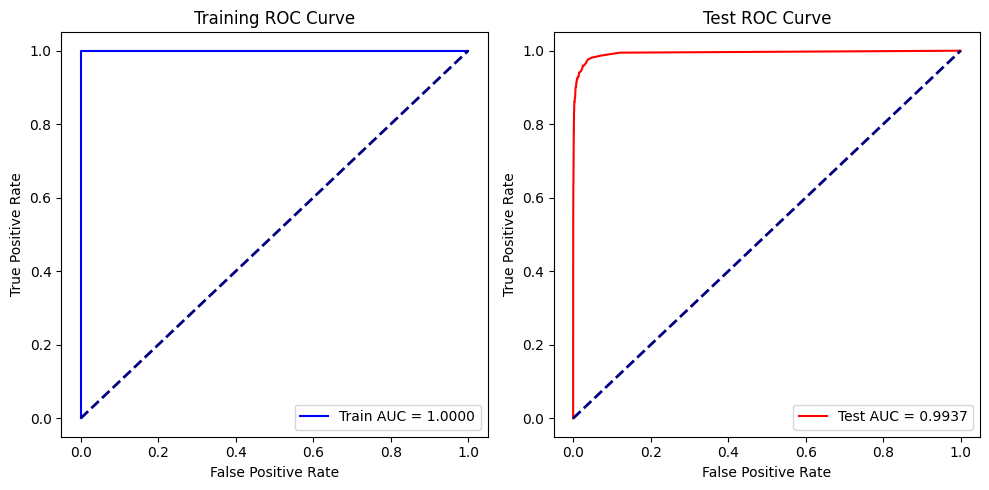

Training Misclassification Rate: 0.0000
Test Misclassification Rate: 0.0076
Out-of-Bag Error: 0.0060


In [51]:
# Train the Random Forest classifier with OOB error tracking
clf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Confusion Matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("Training Confusion Matrix:")
print(cm_train)
print("\nTest Confusion Matrix:")
print(cm_test)

# ROC and AUC for training set
y_train_prob = clf.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob, pos_label=1)
roc_auc_train = auc(fpr_train, tpr_train)

# ROC and AUC for test set
y_test_prob = clf.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob, pos_label=1)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting ROC
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train AUC = {roc_auc_train:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Training ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='red', label=f'Test AUC = {roc_auc_test:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Test ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Misclassification Rates
misclassification_train = 1 - accuracy_score(y_train, y_train_pred)
misclassification_test = 1 - accuracy_score(y_test, y_test_pred)

print(f"Training Misclassification Rate: {misclassification_train:.4f}")
print(f"Test Misclassification Rate: {misclassification_test:.4f}")

# OOB Error
oob_error = 1 - clf.oob_score_
print(f"Out-of-Bag Error: {oob_error:.4f}")


Though Random Forest Classifier get a good result with very low misclassification rate, this might **due to the extremely imbalanced** dataset. Just classify all test instances as negative can get accuracy scrore of 0.9766 (percentage of negative classes in test dataset).

### (d) Research class imbalance in random forest

Methods to address imbalanced data in ramdom forest:

1. Weighted Random Forest: giving higher weights to the minority class. This means that during the splitting process, the algorithm will favor splits that achieve better classification results for the minority class.
2. Balanced Random Forest: equal numbers of instances are sampled from each class to create the bootstrapped datasets. This ensures that each tree in the forest sees a balanced dataset.
3. SMOTE (Synthetic Minority Oversampling Technique) using Standard Random Forest: generate synthetic samples of the minority class. This can help in balancing the classes before training the random forest.

Ref：

https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf

Training Confusion Matrix:
[[59000     0]
 [    1   999]]

Test Confusion Matrix:
[[15612    13]
 [  171   204]]


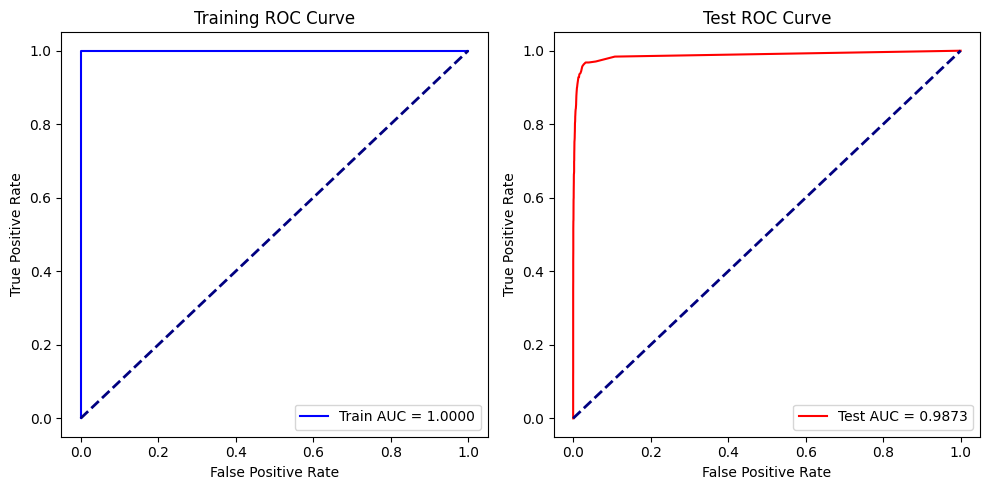

Training Misclassification Rate: 0.0000
Test Misclassification Rate: 0.0115
Out-of-Bag Error: 0.0077


In [104]:
# Train Weighted Random Forest classifier with OOB error tracking
clf = RandomForestClassifier(n_estimators=100, oob_score=True, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Confusion Matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("Training Confusion Matrix:")
print(cm_train)
print("\nTest Confusion Matrix:")
print(cm_test)

# ROC and AUC for training set
y_train_prob = clf.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob, pos_label=1)
roc_auc_train = auc(fpr_train, tpr_train)

# ROC and AUC for test set
y_test_prob = clf.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob, pos_label=1)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting ROC
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train AUC = {roc_auc_train:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Training ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='red', label=f'Test AUC = {roc_auc_test:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Test ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Misclassification Rates
misclassification_train = 1 - accuracy_score(y_train, y_train_pred)
misclassification_test = 1 - accuracy_score(y_test, y_test_pred)

print(f"Training Misclassification Rate: {misclassification_train:.4f}")
print(f"Test Misclassification Rate: {misclassification_test:.4f}")

# OOB Error
oob_error = 1 - clf.oob_score_
print(f"Out-of-Bag Error: {oob_error:.4f}")


Weighted Random Forest get a lower test misclassification rate than standard random forest. This might due to the imbalance in test data. Weighted Random Forest tends to classify as minority class (positive) more than standard random forest while there's still imbalance in test dataset.

### (e) XGBoost and Model Trees

Ref:

https://xgboost.readthedocs.io/en/stable/python/python_api.html

In [ ]:
alphas = [0.001, 0.01, 0.1, 1, 10]
best_alpha = None
best_score = float('-inf')

for alpha in alphas:
    clf = xgb.XGBClassifier(objective='reg:logistic', alpha=alpha)
    scores = cross_val_score(clf, X_train.values, y_train.values, cv=5, scoring='roc_auc')
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

In [59]:
print("Best alpha:", best_alpha)

Best alpha: 0.01


Training Confusion Matrix:
[[59000     0]
 [    1   999]]

Test Confusion Matrix:
[[15608    17]
 [   80   295]]


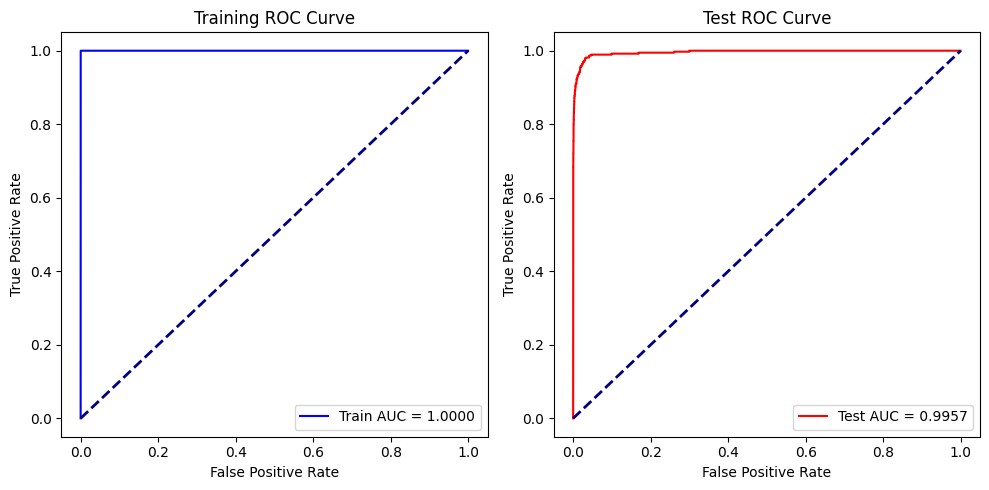

Training Misclassification Rate: 0.0000
Test Misclassification Rate: 0.0061


In [60]:
# Train the model with the best alpha
clf = xgb.XGBClassifier(objective='reg:logistic', alpha=best_alpha)
clf.fit(X_train.values, y_train.values)

# Predict on training and test sets
y_train_pred = clf.predict(X_train.values)
y_test_pred = clf.predict(X_test.values)

# Confusion Matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("Training Confusion Matrix:")
print(cm_train)
print("\nTest Confusion Matrix:")
print(cm_test)

# ROC and AUC for training set
y_train_prob = clf.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob, pos_label=1)
roc_auc_train = auc(fpr_train, tpr_train)

# ROC and AUC for test set
y_test_prob = clf.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob, pos_label=1)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting ROC
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train AUC = {roc_auc_train:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Training ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='red', label=f'Test AUC = {roc_auc_test:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Test ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Misclassification Rates
misclassification_train = 1 - accuracy_score(y_train, y_train_pred)
misclassification_test = 1 - accuracy_score(y_test, y_test_pred)

print(f"Training Misclassification Rate: {misclassification_train:.4f}")
print(f"Test Misclassification Rate: {misclassification_test:.4f}")

Using XGBoost, the test confusion matrix shows **better performance in classifying positive class**, which is minority class. 

(True Positive Rate = $\frac{295}{375}=0.79$, True Positive Rate of standard random forest = $\frac{274}{375}=0.73$)

### (f) Use SMOTE to pre-process your data

The wrong way of doing cross validationis using SMOTE before spliting the data. The right way is doing SMOTE after splitting the data for each fold.

In [68]:
# Assuming X and y are your features and labels
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store evaluation metrics
metrics = defaultdict(list)

# Define the range of alpha values to test
alphas = [0.001, 0.01, 0.1, 1, 10]

for cv_train_index, cv_valid_index in kf.split(X_train, y_train):
    # Split data into training and validation sets for this fold
    X_cv_train, X_cv_valid = X_train.values[cv_train_index], X_train.values[cv_valid_index]
    y_cv_train, y_cv_valid = y_train[cv_train_index], y_train[cv_valid_index]
    
    # Apply SMOTE to the training data only
    smote = SMOTE(random_state=42)
    X_cv_train_smote, y_cv_train_smote = smote.fit_resample(X_cv_train, y_cv_train)
    
    # Train XGBoost with L1-penalized logistic regression for each alpha
    for alpha in alphas:
        clf = xgb.XGBClassifier(objective='reg:logistic', alpha=alpha)
        clf.fit(X_cv_train_smote, y_cv_train_smote)
        
        # Predict on the validation set
        y_pred = clf.predict(X_cv_valid)
        
        # Calculate evaluation metrics
        metrics['alpha'].append(alpha)
        metrics['auc'].append(roc_auc_score(y_cv_valid, y_pred))
        metrics['accuracy'].append(accuracy_score(y_cv_valid, y_pred))
        metrics['confusion_matrix'].append(confusion_matrix(y_cv_valid, y_pred))

In [69]:
# Calculate the average of the metrics across all folds for each alpha
for alpha in alphas:
    indices = [i for i, a in enumerate(metrics['alpha']) if a == alpha]
    avg_auc = np.mean([metrics['auc'][i] for i in indices])
    avg_accuracy = np.mean([metrics['accuracy'][i] for i in indices])
    print(f"Alpha: {alpha}, AUC: {avg_auc}, Accuracy: {avg_accuracy}")

Alpha: 0.001, AUC: 0.8997542372881357, Accuracy: 0.9932833333333335
Alpha: 0.01, AUC: 0.8999322033898304, Accuracy: 0.9936333333333334
Alpha: 0.1, AUC: 0.9004661016949151, Accuracy: 0.9937166666666666
Alpha: 1, AUC: 0.9064406779661016, Accuracy: 0.9938666666666667
Alpha: 10, AUC: 0.9110593220338983, Accuracy: 0.9923166666666667


Training Confusion Matrix:
[[59000     0]
 [    1   999]]

Test Confusion Matrix:
[[15318   307]
 [   44   331]]


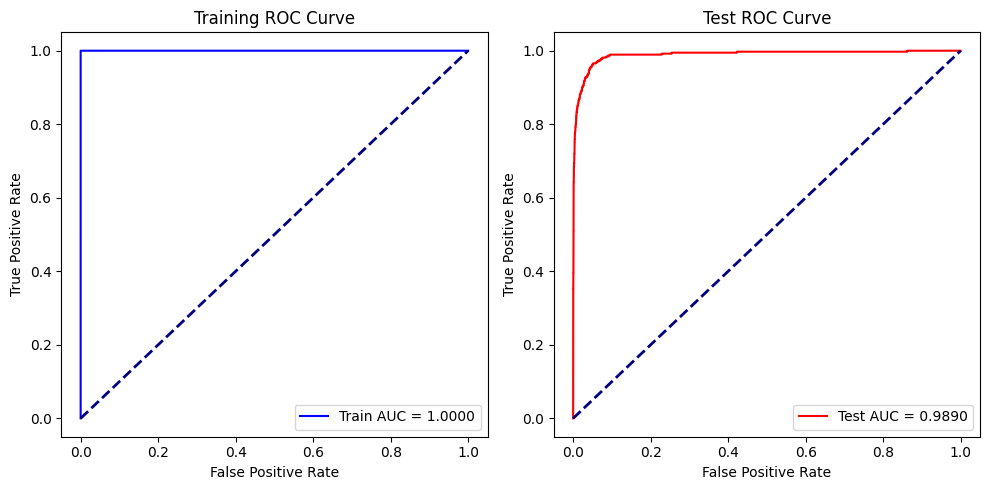

Training Misclassification Rate: 0.0000
Test Misclassification Rate: 0.0219


In [70]:
# Choose the best alpha based on the highest average AUC
best_alpha = alphas[np.argmax([np.mean([metrics['auc'][i] for i in indices]) for alpha in alphas])]

# Train final model on the entire dataset with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train.values, y_train)
clf = xgb.XGBClassifier(objective='reg:logistic', alpha=best_alpha)
clf.fit(X_train_smote, y_train_smote)

# Predict on training and test sets
y_train_pred = clf.predict(X_train.values)
y_test_pred = clf.predict(X_test.values)

# Confusion Matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("Training Confusion Matrix:")
print(cm_train)
print("\nTest Confusion Matrix:")
print(cm_test)

# ROC and AUC for training set
y_train_prob = clf.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob, pos_label=1)
roc_auc_train = auc(fpr_train, tpr_train)

# ROC and AUC for test set
y_test_prob = clf.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob, pos_label=1)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting ROC
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train AUC = {roc_auc_train:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Training ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='red', label=f'Test AUC = {roc_auc_test:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Test ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Misclassification Rates
misclassification_train = 1 - accuracy_score(y_train, y_train_pred)
misclassification_test = 1 - accuracy_score(y_test, y_test_pred)

print(f"Training Misclassification Rate: {misclassification_train:.4f}")
print(f"Test Misclassification Rate: {misclassification_test:.4f}")

Though the test miscalssification rate decreases, the accuracy of classifying positive class increases. 

The true positive rate of XGBoost model is $\frac{295}{375}=0.79$ while true postive rate with SMOTE processing is $\frac{331}{375}=0.88$. 

Thus, the model with SMOTE processing **performs better in classifying minority class**.

## 2. ISLR 6.6.3

As we increase $s$ from 0, 

(a) training RSS will steadily decrease.

(b) test RSS will decrease initially, and then eventually start increasing in a U shape.

(c) variance will steadily increase.

(d) (squared) bias will steadily decrease.

(e) the irreducible error will remain constant.

## 3. ISLR 6.6.5

(a) 
The ridge regression optimization problem is to minimize the residual sum of squares (RSS) with an L2 penalty on the coefficients:

$min \sum_{i=1}^{n} (y_i - \hat{\beta_0} - \sum_{j=1}^{p} \hat{\beta_j} x_{ij})^2 + \lambda \sum_{j=1}^{p} \hat{\beta_j}^2$

Given $n=2, p=2, \hat{\beta_0}=0$, the optimization problem is:

$min (y_1 - \hat{\beta_1}x_{11} - \hat{\beta_2}x_{12})^2 + (y_2 - \hat{\beta_1}x_{21} - \hat{\beta_2}x_{22})^2 + \lambda(\hat{\beta_1}^2 + \hat{\beta_2}^2)$

Plugging $x_{11}=x_{12}, x_{21}=x_{22},$

$min (y_1 - (\hat{\beta_1} + \hat{\beta_2}) x_{11})^2 + (y_2 - (\hat{\beta_1} + \hat{\beta_2}) x_{21})^2 + \lambda (\hat{\beta_1}^2 + \hat{\beta_2}^2)$

(b) To minimize the above objective function $J(\hat{\beta_1}, \hat{\beta_2})$, set the partial derivatives of $\hat{\beta_1}, \hat{\beta_2}$ to 0.

$\frac{\partial J}{\partial \hat{\beta_1}} = -2x_{11} * (y_1 - (\hat{\beta_1} + \hat{\beta_2})x_{11}) -2x_{21} * (y_2 - (\hat{\beta_1} + \hat{\beta_2})x_{21}) + 2\lambda \hat{\beta_1} = 0$

$\frac{\partial J}{\partial \hat{\beta_2}} = -2x_{11} * (y_1 - (\hat{\beta_1} + \hat{\beta_2})x_{11}) -2x_{21} * (y_2 - (\hat{\beta_1} + \hat{\beta_2})x_{21}) + 2\lambda \hat{\beta_2} = 0$

Subtract the first formula from the second formula, the remaining terms are:

$2\lambda \hat{\beta_2} - 2\lambda \hat{\beta_1} = 0$

$\hat{\beta_1} = \hat{\beta_2}$

Thus, in this case, the ridge coefficient estimates satisfy $\hat{\beta_1} = \hat{\beta_2}$.

(c) 
The lasso regression optimization problem is to minimize the residual sum of squares (RSS) with an L1 penalty on the coefficients:

$min \sum_{i=1}^{n} (y_i - \hat{\beta_0} - \sum_{j=1}^{p} \hat{\beta_j} x_{ij})^2 + \lambda \sum_{j=1}^{p} |\hat{\beta_j}|$

Given $n=2, p=2, \hat{\beta_0}=0$, the optimization problem is:

$min (y_1 - \hat{\beta_1}x_{11} - \hat{\beta_2}x_{12})^2 + (y_2 - \hat{\beta_1}x_{21} - \hat{\beta_2}x_{22})^2 + \lambda(|\hat{\beta_1}| + |\hat{\beta_2}|)$

Plugging $x_{11}=x_{12}, x_{21}=x_{22},$

$min (y_1 - (\hat{\beta_1} + \hat{\beta_2}) x_{11})^2 + (y_2 - (\hat{\beta_1} + \hat{\beta_2}) x_{21})^2 + \lambda (|\hat{\beta_1}| + |\hat{\beta_2}|)$

(d) Similar to the ridge optimization problem, 

$\frac{\partial RSS}{\partial \hat{\beta_1}} = \frac{\partial RSS}{\partial \hat{\beta_2}}$

While the L1 penalty term is $\lambda(|\hat{\beta_1}| + |\hat{\beta_2}|)$, depending on the magnitude of $\hat{\beta_1}$ and $\hat{\beta_2}$, different solutions can have the same or almost the same objective function value. Since the absolute value function is not differentiable at zero, there's no clear gradient pointing towards one unique solution.

Thus, there can be multiple values of $\hat{\beta_1}$ and $\hat{\beta_1}$ that can minimize obejective function. 


## 4. ISLR 8.4.5

10 estimates of $P(Class is Red|X)$:

0.1,0.15,0.2,0.2,0.55,0.6,0.6,0.65,0.7, 0.75

The classfication results of 10 estimates are:

Green, Green, Green, Green, Red, Red, Red, Red, Red, Red

The average probabilty of 10 estimates is: $\frac{0.1+0.15+0.2+0.2+0.55+0.6+0.6+0.65+0.7+ 0.75}{10} = 0.45$

Under the majority voting approach, given specific value of X, the class is **Red** since there are **6 estimates classified as Red**.

Under the average probability approach, given specific value of X, the class is **Green** since the **average probability $P(Class is Red|X)$ of 10 estimates is 0.45 < 0.5**.

## 5. ISLR 9.7.3

### a. Sketch the observations

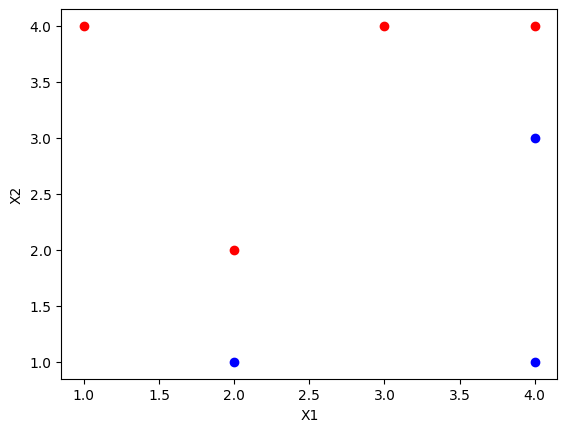

In [8]:
X_red = [[3, 2, 4, 1], [4, 2, 4, 4]]
X_blue = [[2, 4, 4], [1, 3, 1]]

plt.scatter(X_red[0], X_red[1], c='red')
plt.scatter(X_blue[0], X_blue[1], c='blue')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### b. Sketch the optimal separating hyperplane

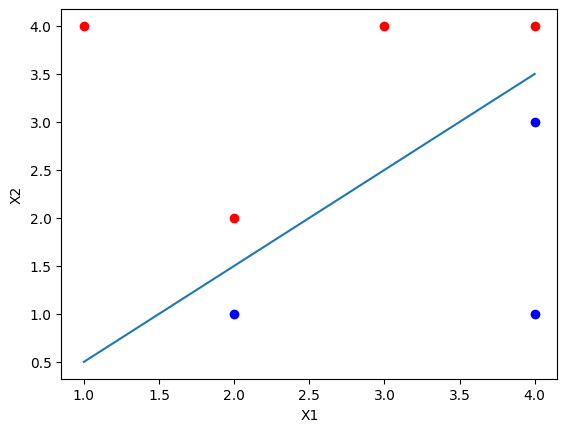

In [10]:
X_red = [[3, 2, 4, 1], [4, 2, 4, 4]]
X_blue = [[2, 4, 4], [1, 3, 1]]
x = list(range(1, 5))
y = [i - 0.5 for i in x]

plt.scatter(X_red[0], X_red[1], c='red')
plt.scatter(X_blue[0], X_blue[1], c='blue')
plt.plot(x, y)
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

Equation of hyperplane is $0.5-X_1+X_2=0$

### c. Describe the classification rule

Classify to Red if $0.5-X_1+X_2 > 0$, and classify to Blue otherwise.

### d. Indicate the margin for the maximal margin hyperplane

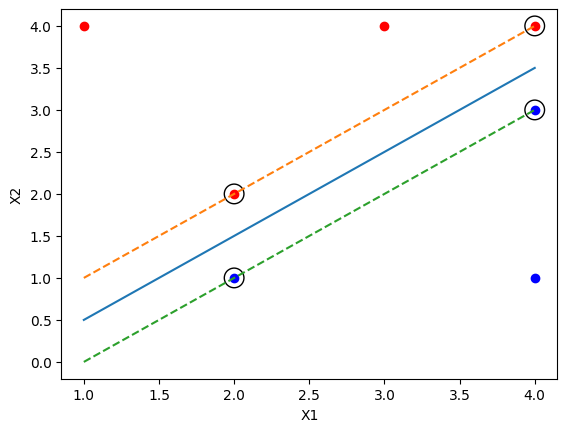

In [100]:
X_red = [[3, 2, 4, 1], [4, 2, 4, 4]]
X_blue = [[2, 4, 4], [1, 3, 1]]
x = list(range(1, 5))
y_hyperplane = [i - 0.5 for i in x]
y_margin_1 = x
y_marigin_2 = [i - 1 for i in x]

plt.scatter(X_red[0], X_red[1], c='red')
plt.scatter(X_blue[0], X_blue[1], c='blue')
plt.plot(x, y_hyperplane)
plt.plot(x, y_margin_1, '--')
plt.plot(x, y_marigin_2, '--')
plt.scatter([2, 4, 2, 4], [1, 3, 2, 4], s=200,
           linewidth=1, facecolors='none', edgecolors='k')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

###  e. Indicate the support vectors for the maximal margin classifier.

The support vectors are the points (2,1), (2,2), (4,3) and (4,4).

### f.

The seventh observation is (4, 1). If we moved the observation (4,1), we would not change the maximal margin hyperplane as it is not a support vector.

### g. Sketch a hyperplane that is not the optimal separating hyperplane

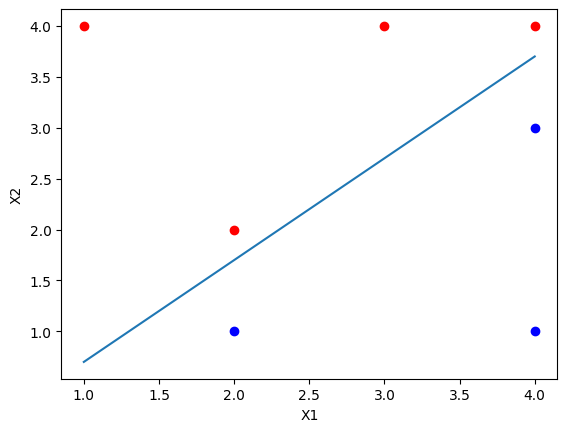

In [101]:
X_red = [[3, 2, 4, 1], [4, 2, 4, 4]]
X_blue = [[2, 4, 4], [1, 3, 1]]
x = list(range(1, 5))
y = [i - 0.3 for i in x]

plt.scatter(X_red[0], X_red[1], c='red')
plt.scatter(X_blue[0], X_blue[1], c='blue')
plt.plot(x, y)
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

### h. Draw an additional observation

Add an observation (3, 1) with Red class can make the two classes are no longer separable by a hyperplane.

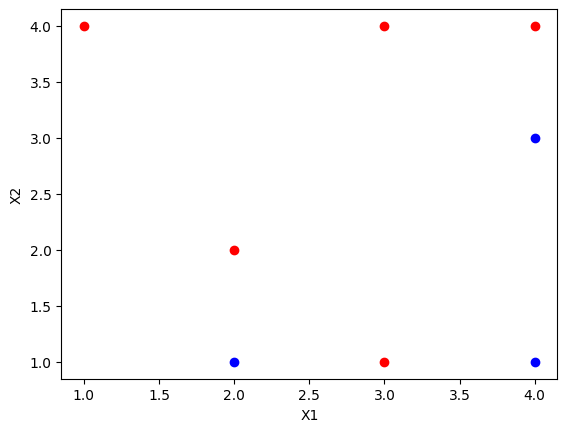

In [103]:
X_red = [[3, 2, 4, 1, 3], [4, 2, 4, 4, 1]]
X_blue = [[2, 4, 4], [1, 3, 1]]

plt.scatter(X_red[0], X_red[1], c='red')
plt.scatter(X_blue[0], X_blue[1], c='blue')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()